# Predictions for HRES at 0.1 Degrees

In this example, we will download IFS HRES analysis data at 0.1 degrees resolution for 11 May 2022 from the [Research Data Archive](https://rda.ucar.edu/datasets/d113001/#) and run Aurora on this data. We will use the version of Aurora that was fine-tuned on IFS HRES analysis at 0.1 degrees resolution.

Running this notebook requires additional Python packages. You can install these as follows:

```
pip install requests cfgrib matplotlib
```


## Downloading the Data

To start, we download the data from [Research Data Archive](https://rda.ucar.edu/datasets/d113001/#).

In [1]:
from datetime import datetime
from pathlib import Path

import requests
import xarray as xr

# Data will be downloaded here.
download_path = Path("~/downloads/hres_0.1").expanduser()

# Day to download. This will download all times for that day.
date = datetime(2022, 5, 11)

# Each variable has a number associated with it. This is the number that will be used in
# the RDA request.
var_nums = {
    "2t": "167",  # 2m temperature
    "10u": "165",  # 10m u-component of wind
    "10v": "166",  # 10m v-component of wind
    "msl": "151",  # Mean sea level pressure
    "t": "130",  # Temperature
    "u": "131",  # u-component of wind (atmospheric)
    "v": "132",  # v-component of wind (atmospheric)
    "q": "133",  # Specific humidity (atmospheric)
    "z": "129",  # Geopotential
    "slt": "043",  # Soil type
    "lsm": "172",  # Land-sea mask
}

# Construct the URLs to download the data from.
downloads: dict[Path, str] = {}
for v in ["2t", "10u", "10v", "msl", "z", "slt", "lsm"]:
    downloads[download_path / date.strftime(f"surf_{v}_%Y-%m-%d.grib")] = (
        f"https://data.rda.ucar.edu/ds113.1/"
        f"ec.oper.an.sfc/{date.year}{date.month:02d}/ec.oper.an.sfc.128_{var_nums[v]}_{v}."
        f"regn1280sc.{date.year}{date.month:02d}{date.day:02d}.grb"
    )
for v in ["z", "t", "u", "v", "q"]:
    for hour in [0, 6, 12, 18]:
        prefix = "uv" if v in {"u", "v"} else "sc"
        downloads[download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_{hour:02d}.grib")] = (
            f"https://data.rda.ucar.edu/ds113.1/"
            f"ec.oper.an.pl/{date.year}{date.month:02d}/ec.oper.an.pl.128_{var_nums[v]}_{v}."
            f"regn1280{prefix}.{date.year}{date.month:02d}{date.day:02d}{hour:02d}.grb"
        )

# Perform the downloads.
for target, source in downloads.items():
    if not target.exists():
        print(f"Downloading {source}")
        target.parent.mkdir(parents=True, exist_ok=True)
        response = requests.get(source)
        response.raise_for_status()
        with open(target, "wb") as f:
            f.write(response.content)
print("Downloads finished!")

Downloads finished!


## Preparing a Batch

We convert the downloaded data to an `aurora.Batch`, which is what the model requires.

In [2]:
import numpy as np
import torch

from aurora import Batch, Metadata

# Load these pressure levels.
levels = (1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50)


def load_surf(v: str, v_in_file: str) -> torch.Tensor:
    """Load the downloaded surface-level or static variable `v` for hours 00 and 06."""
    ds = xr.open_dataset(download_path / date.strftime(f"surf_{v}_%Y-%m-%d.grib"), engine="cfgrib")
    data = ds[v_in_file].values[:2]  # Use hours 00 and 06.
    data = data[None]  # Insert a batch dimension.
    return torch.from_numpy(data)


def load_atmos(v: str) -> torch.Tensor:
    """Load the downloaded atmospheric variable `v` for hours 00 and 06."""
    ds_00 = xr.open_dataset(
        download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_00.grib"), engine="cfgrib"
    )
    ds_06 = xr.open_dataset(
        download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_06.grib"), engine="cfgrib"
    )
    # Select the right pressure levels.
    ds_00 = ds_00[v].sel(isobaricInhPa=list(levels))
    ds_06 = ds_06[v].sel(isobaricInhPa=list(levels))
    data = np.stack((ds_00.values, ds_06.values), axis=0)
    data = data[None]  # Insert a batch dimension.
    return torch.from_numpy(data)


# Extract the latitude and longitude from an arbitrary downloaded file.
ds = xr.open_dataset(next(iter(downloads.keys())), engine="cfgrib")

batch = Batch(
    surf_vars={
        "2t": load_surf("2t", "t2m"),
        "10u": load_surf("10u", "u10"),
        "10v": load_surf("10v", "v10"),
        "msl": load_surf("msl", "msl"),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": load_surf("z", "z")[0, 0],
        "slt": load_surf("slt", "slt")[0, 0],
        "lsm": load_surf("lsm", "lsm")[0, 0],
    },
    atmos_vars={
        "t": load_atmos("t"),
        "u": load_atmos("u"),
        "v": load_atmos("v"),
        "q": load_atmos("q"),
        "z": load_atmos("z"),
    },
    metadata=Metadata(
        lat=torch.from_numpy(ds.latitude.values),
        lon=torch.from_numpy(ds.longitude.values),
        time=(date.replace(hour=6),),
        atmos_levels=levels,
    ),
)

In [3]:
# Regrid the batch to 0.1 degrees resolution. Note that this is a convenience function
# which is not optimised for speed or accuracy. Use at your own risk!
batch = batch.regrid(res=0.1)

## Loading and Running the Model

Finally, we are ready to load and run the model and visualise the predictions. We perform a roll-out for two steps, which produces predictions for hours 12:00 and 18:00.

In [4]:
from aurora import AuroraHighRes, rollout

model = AuroraHighRes(
    # Use manually downloaded and regridded static variables.
    surf_stats={"z": (-3.270407e03, 6.540335e04)},
)
model.load_checkpoint("microsoft/aurora", "aurora-0.1-finetuned.ckpt")

model.eval()
model = model.to("cuda")

with torch.inference_mode():
    preds = [pred.to("cpu") for pred in rollout(model, batch, steps=2)]

model = model.to("cpu")

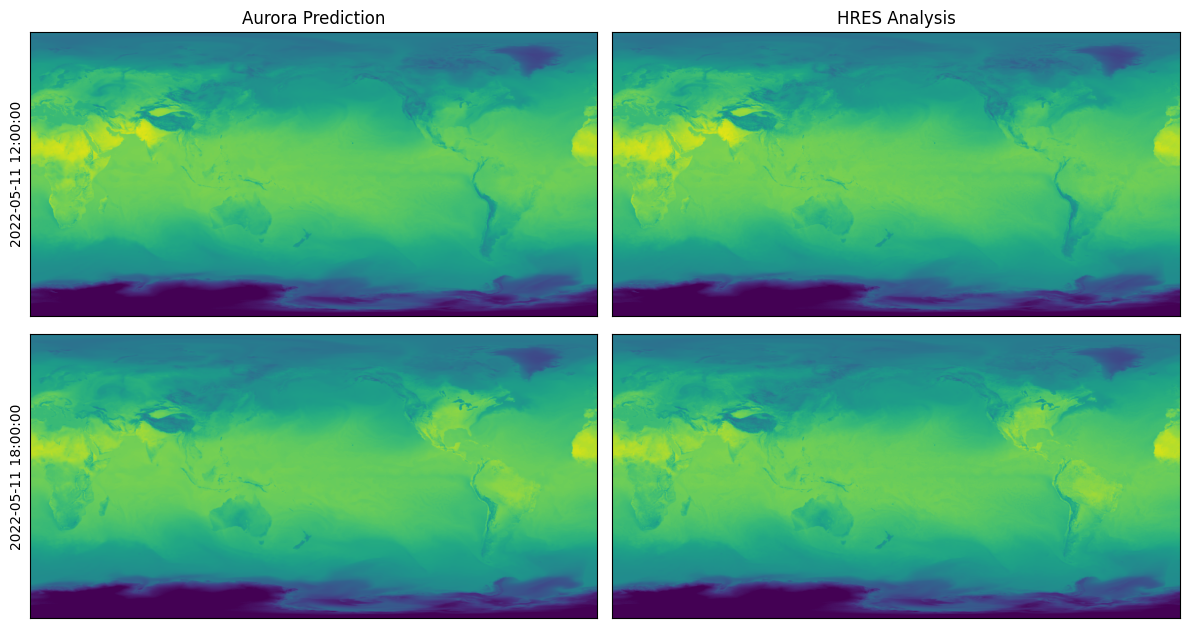

In [6]:
import matplotlib.pyplot as plt

truth = xr.open_dataset(download_path / date.strftime("surf_2t_%Y-%m-%d.grib"), engine="cfgrib")

fig, ax = plt.subplots(2, 2, figsize=(12, 6.5))

for i in range(ax.shape[0]):
    pred = preds[i]

    ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15, vmin=-50, vmax=50)
    ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax[i, 0].set_title("Aurora Prediction")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    ref = truth["t2m"][2 + i].values
    ax[i, 1].imshow(ref - 273.15, vmin=-50, vmax=50)
    if i == 0:
        ax[i, 1].set_title("HRES Analysis")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])

plt.tight_layout()